# Analyzing the success of Kickstarter projects 

Kickstarter is a crowdfunding platform where different creators show their projects. If people like a project, they can pledge money and fund it to make it a reality. This platform works over multiple countries around the world and almost any field of creative work can be found in it. Currently, is among the biggest source of crowdfunding. 

The general purpose of this project is to give a glimpse on how the diverse types of crowdfunding projects evolved and give a notion of the most successful and failed types, all of this through the powerful lens of data analysis. In order to achieve this, I aspire to answer three questions, looking for insights that lie within a dataset that gathers descriptions of almost 379000 projects, ranging from 2009 (year in which Kickstarter was founded) to the first months of 2018, with features such as the type of project, the amount of money they collect or their country of origin. This dataset was gathered by Mickaël Mouillé with data provided by the Kickstarter platform itself (https://www.kaggle.com/kemical/kickstarter-projects). 

This notebook have four parts:  

- __Description of the dataset and preparation of the data__
- __Question 1:__ What are the most successful, failed and canceled kind of projects?
- __Question 2:__ Is there any seasonality on project launches?
- __Question 3:__ How the platform and product areas evolved through the years?

Let's begin!

## Description of the dataset and preparation of the data:

In [1]:
# Import analysis and visualization of data libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import calendar
import matplotlib.pyplot as plt
%matplotlib inline

In first place, I would want to give a glance on the data, its structure and type of contents:

In [2]:
# Dataframe load:
df = pd.read_csv('ks-projects-201801.csv')
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


As you can see, most of the column names are pretty self explanatory: the projects are described by a (presumably) unique ID, their names, the category and sub-category they fit in, the deadline for the pledge/funding stage, the money goal their creators aspire to gather, the date of launching of the pledge/funding stage, the amount of backers, and their country of origin. The three last columns (__*usd pledged*__, __*usd_pledged_real*__, __*usd_goal_real*__), corresponds to the conversion to USD of the amount of money pledged. Let´s confirm if the dataset have _NaN_ values:

In [3]:
#There are unique, numeric identifiers for each project:
print('ID column data type:', df.ID.dtype)
print('ID column amount of unique values:', len(df.ID.unique()))
print('Number of projects:', df.shape[0])

ID column data type: int64
ID column amount of unique values: 378661
Number of projects: 378661


In [4]:
#Is there any NaN values?  
print('Columns with NaN values:')
print(df.columns[df.isnull().mean()!=0].values) 

Columns with NaN values:
['name' 'usd pledged']


Two columns have NaN values: __"name"__ and __"usd pledge"__.

In [5]:
#Let's see how many projects have no name
df.name.isnull()[df.name.isnull()==True]

166851    True
307234    True
309991    True
338931    True
Name: name, dtype: bool

In [6]:
#Let's see how many projects have no conversion to USD
usd_pledged_null = df['usd pledged'].isnull()[df['usd pledged'].isnull()==True]
print('Amount of NaN values in the "usd pledged" column:',len(usd_pledged_null))

Amount of NaN values in the "usd pledged" column: 3797


Since the name of a project do not give us relevant insights for the questions and there are only four projects without it, we can leave it that way. On the other hand, there are a significant amount of NaN values in the __usd pledged__ column. Also, it seems that this column give redundant information, compared to __usd_pledged_real__ column. What happen? Let's see if the other features of these projects with NaN's give us any hint: 

In [7]:
# df_usd_pledged_null: rows with "usd_pledged" NaN values
df_usd_pledged_null = df.iloc[usd_pledged_null.index]
df_usd_pledged_null

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
169,1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.0,2014-08-06 21:28:36,555.00,undefined,0,"N,0""",NaN,555.00,6500.00
328,100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.0,2015-08-04 12:05:17,4767.00,undefined,0,"N,0""",NaN,3402.08,3211.53
632,1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.0,2015-03-10 20:06:13,3576.00,undefined,0,"N,0""",NaN,3576.00,3500.00
647,1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.0,2015-11-02 22:09:19,7007.80,undefined,0,"N,0""",NaN,7007.80,6000.00
749,1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.0,2016-02-23 03:09:49,3660.38,undefined,0,"N,0""",NaN,3660.38,3000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378233,997971307,"EQUUS International Film Festival®, all-equine...",Film & Video,Film & Video,USD,2015-02-03,7500.0,2014-12-05 04:19:14,10.00,undefined,0,"N,0""",NaN,10.00,7500.00
378303,998319149,Emily 2050 - Short Film,Film & Video,Film & Video,CAD,2014-05-23,3000.0,2014-04-08 00:30:09,3102.00,undefined,0,"N,0""",NaN,2845.61,2752.04
378434,9988744,Matthew Stephens Music,Music,Music,USD,2016-02-05,5000.0,2016-01-06 21:59:23,235.00,undefined,0,"N,0""",NaN,235.00,5000.00
378585,999610349,Lady Vendredi: Afrofuturist concept 12 inch EP,Music,Music,GBP,2015-10-19,2000.0,2015-09-21 22:33:18,2125.00,undefined,0,"N,0""",NaN,3273.36,3080.81


It seems that none of these projects have a valid country name:

In [8]:
#Are all of the projects with NaN values from the same country?
print('Number of projects with weird country names:', len(df_usd_pledged_null.country))
print('Number of countries found for the null values in "usd_pledge":', 
      len(df_usd_pledged_null.country.unique())
     )

Number of projects with weird country names: 3797
Number of countries found for the null values in "usd_pledge": 1


In [9]:
#What is this weird country?
print('Weird "country" found:', df_usd_pledged_null.country.unique()[0])

Weird "country" found: N,0"


We can see that these NaN values are product of a bad conversion of pledge amounts, since it was calculated on an inexistent country. This is the reason for the "real" part in __usd_pledged_real__ (presumably the __usd_pledged_real__ column calculate the conversion with the country column instead of currency). Hence, we can drop __usd pledged__ column:

In [10]:
df.drop(columns=['usd pledged'], inplace=True)

Just in case, let´s confirm there are no other weird countries:

In [11]:
df.country.value_counts()

US      292627
GB       33672
CA       14756
AU        7839
DE        4171
N,0"      3797
FR        2939
IT        2878
NL        2868
ES        2276
SE        1757
MX        1752
NZ        1447
DK        1113
IE         811
CH         761
NO         708
HK         618
BE         617
AT         597
SG         555
LU          62
JP          40
Name: country, dtype: int64

There are no more weird countries indeed. Are there more categorical data in the dataset? More weird values?:

In [12]:
# Unique project categories:
print('Number of values in "category" column:',len(df.category.unique()))

Number of values in "category" column: 159


In [13]:
# Unique project main categories:
print('Number of values in "main_category" column:',
      len(df.main_category.unique())
     )
print("")
print('Values:', df.main_category.unique())

Number of values in "main_category" column: 15

Values: ['Publishing' 'Film & Video' 'Music' 'Food' 'Design' 'Crafts' 'Games'
 'Comics' 'Fashion' 'Theater' 'Art' 'Photography' 'Technology' 'Dance'
 'Journalism']


In [14]:
# Unique currencies:
print('Number of values in "currency" column:',len(df.currency.unique()))
print("")
print('Values:', df.currency.unique())

Number of values in "currency" column: 14

Values: ['GBP' 'USD' 'CAD' 'AUD' 'NOK' 'EUR' 'MXN' 'SEK' 'NZD' 'CHF' 'DKK' 'HKD'
 'SGD' 'JPY']


In [15]:
# Unique project states:
print('Number of values in "state" column:',len(df.state.unique()))
print("")
print('Values:', df.state.unique())

Number of values in "state" column: 6

Values: ['failed' 'canceled' 'successful' 'live' 'undefined' 'suspended']


Also, we can confirm that the columns with date information (__deadline__ and __launched__) have date consistent format and corresponds to actual past years, months and days:

In [16]:
def verify_date_format(string):
    """Verifies if a string have a correct date format and sound information.
        Args:
        string (str): string with presumed datetime format
        
        Return:
        True, False (bool): If True, the string has datetime format
    """
    date = re.search(r'(\d{4}-\d{2}-\d{2})', string)[0]
    date_list = date.split('-')
    year = int(date_list[0])
    month = int(date_list[1])
    day = int(date_list[2])
    if (re.search(r'(\d{4}-\d{2}-\d{2})', date) and # Verify the year-month-day format
            year <= 2019 and month <= 12 and day <= 31): # Verify there is no weird dates
        return True
    else:
        return False

In [17]:
#Verifies "deadline" data format
if df.deadline.apply(verify_date_format).mean() == 1.0:
    print('"deadline" column have consistent date info.')

"deadline" column have consistent date info.


In [18]:
#Verifies "launched" data format
if df.launched.apply(verify_date_format).mean() == 1.0:
    print('"launched" column have consistent date info.')

"launched" column have consistent date info.


All dates info seems correct.

In order to find any time related pattern in subsequent analysis, I have to convert the date info to a data type that makes possible work on them:

In [19]:
# Convert "deadline" and "launched" to datetime object series:
datetime_deadline = pd.to_datetime(df["deadline"], format='%Y-%m-%d')
df["deadline"] = datetime_deadline


datetime_launched = pd.to_datetime(df["launched"], format='%Y-%m-%d %H:%M:%S')
df["launched"] = datetime_launched

print('First project on the dataset was launched on', df.launched.describe()['first'].strftime('%b %d, %Y'))
print('Last project on the dataset was launched on', df.launched.describe()['last'].strftime('%b %d, %Y'))
print(' ')
print('First project\'s deadline:', df.deadline.describe()['first'].strftime('%b %d, %Y'))
print('Last project\'s deadline:', df.deadline.describe()['last'].strftime('%b %d, %Y'))

First project on the dataset was launched on Jan 01, 1970
Last project on the dataset was launched on Jan 02, 2018
 
First project's deadline: May 03, 2009
Last project's deadline: Mar 03, 2018


Wait, that first project launch date is weird. We must see the details of this/these projects: 

In [20]:
# df rows with projects launched in 1970
df[df.launched == df.launched.describe()['first']]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged_real,usd_goal_real
2842,1014746686,Salt of the Earth: A Dead Sea Movie (Canceled),Film & Video,Film & Video,USD,2010-09-15,5000.0,1970-01-01 01:00:00,0.0,canceled,0,US,0.0,5000.00
48147,1245461087,1st Super-Size Painting - Social Network Owned...,Art,Art,USD,2010-08-14,15000.0,1970-01-01 01:00:00,0.0,canceled,0,US,0.0,15000.00
75397,1384087152,"""ICHOR"" (Canceled)",Film & Video,Film & Video,USD,2010-05-21,700.0,1970-01-01 01:00:00,0.0,canceled,0,US,0.0,700.00
94579,1480763647,"Support Solo Theater! Help ""Ungrateful Daughte...",Theater,Theater,USD,2010-06-01,4000.0,1970-01-01 01:00:00,0.0,canceled,0,US,0.0,4000.00
247913,330942060,"Help RIZ Make A Charity Album: 8 Songs, 8 Caus...",Music,Music,USD,2010-05-04,10000.0,1970-01-01 01:00:00,0.0,canceled,0,US,0.0,10000.00
273779,462917959,Identity Communications Infographic (Canceled),Design,Design,USD,2010-04-10,500.0,1970-01-01 01:00:00,0.0,canceled,0,US,0.0,500.00
319002,69489148,Student Auditions Music 2015,Publishing,Publishing,CHF,2015-10-31,1900.0,1970-01-01 01:00:00,0.0,suspended,0,CH,0.0,1905.97


None of these projects seems to be a 70´s project (besides the fact that Kickstarter was launched in 2009). Because there are very few projects with this problem compared to the total amount, we can get rid of them for later time series analysis in a new dataframe __df_fixed__:

In [21]:
df_fixed = df[~(df.launched == df.launched.describe()['first'])]
# Verifies again that launch dates are sound now
print('First project on the fixed dataset was launched on', 
      df_fixed.launched.describe()['first'].strftime('%b %d, %Y')
     )

First project on the fixed dataset was launched on Apr 21, 2009


Finally, I convert the __category__, __main_category__, __state__ and __country__ columns data type to categorical for performance enhance:  

In [23]:
df_fixed.loc[:, 'main_category'] = df_fixed.loc[:, 'main_category'].astype('category')
df_fixed.loc[:, 'category'] = df_fixed.loc[:, 'category'].astype('category')
df_fixed.loc[:, 'country'] = df_fixed.loc[:, 'country'].astype('category')
df_fixed.loc[:,'state'] = df_fixed.loc[:, 'state'].astype('category')
df_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378654 entries, 0 to 378660
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ID                378654 non-null  int64         
 1   name              378650 non-null  object        
 2   category          378654 non-null  category      
 3   main_category     378654 non-null  category      
 4   currency          378654 non-null  object        
 5   deadline          378654 non-null  datetime64[ns]
 6   goal              378654 non-null  float64       
 7   launched          378654 non-null  datetime64[ns]
 8   pledged           378654 non-null  float64       
 9   state             378654 non-null  category      
 10  backers           378654 non-null  int64         
 11  country           378654 non-null  category      
 12  usd_pledged_real  378654 non-null  float64       
 13  usd_goal_real     378654 non-null  float64       
dtypes: c



Alright, generally speaking, it seems that the dataset is ready for bring us answers!

## Question 1: What are the most successful, failed and canceled kind of projects?

#### Distribution of projects:
In order to see a panoramic view of the different projects on the platform, we can plot its distribution over the  categories they belong:

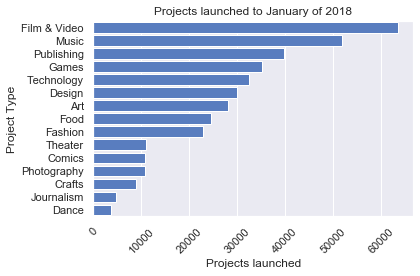

In [24]:
#Distribution of all the projects registered in the dataset, per project category:
df_fixed.main_category.astype('category')
projects_per_cat = df_fixed.groupby('main_category').ID.count().sort_values(ascending=False)

#Plot:
sns.set(style="darkgrid")
sns.set_color_codes("muted")
sns.barplot(projects_per_cat.values, list(projects_per_cat.index), color='b')
plt.title('Projects launched to January of 2018')
plt.xlabel('Projects launched')
plt.ylabel('Project Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('projects_launched.png', dpi=150, bbox_inches='tight')

We can see a notorious diversity of projects, where a remarkable supply of audiovisual projects stands out.  What data can tell us about their success or failure? 

In [25]:
# Amount of projects launched according to its funding state
print('Projects count, according to its funding state:')

print(" ")

print('Succesful projects: {} ({}%)'.format(df_fixed.state.value_counts().loc['successful'],
                                        round(df_fixed.state.value_counts().loc['successful']*100/
                                        df_fixed.shape[0],2)))
print(" ")

print('Failed projects: {} ({}%)'.format(df_fixed.state.value_counts().loc['failed'],
                                        round(df_fixed.state.value_counts().loc['failed']*100/
                                        df_fixed.shape[0],2)))

print(" ")

print('Canceled projects: {} ({}%)'.format(df_fixed.state.value_counts().loc['canceled'],
                                        round(df_fixed.state.value_counts().loc['canceled']*100/
                                        df_fixed.shape[0],2)))

Projects count, according to its funding state:
 
Succesful projects: 133956 (35.38%)
 
Failed projects: 197719 (52.22%)
 
Canceled projects: 38773 (10.24%)


What about the performance of each type of project? We can group each project category according its pledge state:

In [26]:
# Amount of projects launched according its kind and funding state
print('Projects count, according to its type and funding state:')
projects_per_cat_state = df_fixed.groupby(['state', 'main_category']).count()['ID']
projects_per_cat_state

Projects count, according to its type and funding state:


state      main_category
canceled   Art              2221.0
           Comics            842.0
           Crafts            843.0
           Dance             163.0
           Design           4151.0
                             ...  
undefined  Music            2234.0
           Photography         1.0
           Publishing        462.0
           Technology          3.0
           Theater             1.0
Name: ID, Length: 90, dtype: float64

In [27]:
# Most succesful kind of project:
most_succesful_series = (projects_per_cat_state.loc[('successful', )] / 
                         df.main_category.value_counts()
                        ).sort_values(ascending=False).apply(
                        lambda x: str(round(x*100, 2)).format('.%s')+' %')
print('Most successful kinds of project:')
most_succesful_series

Most successful kinds of project:


Dance           62.05 %
Theater         59.87 %
Comics           54.0 %
Music           46.61 %
Art             40.88 %
Film & Video    37.15 %
Games           35.53 %
Design          35.08 %
Publishing      30.85 %
Photography     30.66 %
Food            24.73 %
Fashion         24.51 %
Crafts          24.01 %
Journalism      21.28 %
Technology      19.75 %
dtype: object

Although there are relatively few escenic projects, they are very succesful at get funded!. Same applies for art and comics projects.

In [28]:
# Most failed kind of project:
most_failed_series = (projects_per_cat_state.loc[('failed', )] / 
                      df.main_category.value_counts()
                     ).sort_values(ascending=False).apply(
                     lambda x: str(round(x*100, 2)).format('.%s')+' %')
print('Most failed kinds of project:')
most_failed_series

Most failed kinds of project:


Journalism      65.97 %
Food            64.91 %
Crafts          64.74 %
Technology       63.3 %
Fashion         62.16 %
Photography     59.23 %
Publishing      58.05 %
Film & Video    51.75 %
Art             50.19 %
Design          49.27 %
Games           45.42 %
Music            41.9 %
Comics           37.3 %
Theater         33.98 %
Dance           32.78 %
dtype: object

Taking into account the last two data tables, Technology and Journalism projects seem to appear as a particularly difficult type of projects to get funded.

In [29]:
# Most canceled kind of project:
most_canceled_series = (projects_per_cat_state.loc[('canceled', )] / 
                        df.main_category.value_counts()
                       ).sort_values(ascending=False).apply(
                       lambda x: str(round(x*100, 2)).format('.%s')+' %') 

print('Most canceled kinds of project:')
most_canceled_series

Most canceled kinds of project:


Games            17.6 %
Technology      14.48 %
Design           13.8 %
Fashion         11.61 %
Journalism       11.0 %
Crafts           9.57 %
Photography      9.15 %
Film & Video     9.05 %
Publishing       9.03 %
Food             8.99 %
Art              7.89 %
Comics           7.78 %
Music            6.36 %
Theater          5.56 %
Dance            4.33 %
dtype: object

Canceled projects referred to projects that drop their intend to be funded before deadline. What could be the reason of so many games die before funding? is a good question for later analysis.

## Question 2: Is there any seasonality on project launches?

Launch timing seems to be a important factor to get a project funded. Can we see any tendency in the period of time a project is searching for funding or the most fruitful season for crowdfunding? Let's find out.

As a first step, I create a new column __time_on_pledge__ where we can see the amount of time the project where intended to collect funds: 

In [31]:
# New column with period between launch and deadline:
df_fixed.loc[:,'expected_time_on_pledge'] = df_fixed['deadline'] - df_fixed['launched']
df_fixed['expected_time_on_pledge'].head()

0   58 days 11:47:32
1   59 days 19:16:03
2   44 days 23:39:10
3   29 days 20:35:49
4   55 days 15:24:57
Name: expected_time_on_pledge, dtype: timedelta64[ns]

Now we can know the mean period of pledge time intended by the creator per main category:

In [32]:
# Mean amount of time between launch and deadline intended by project category:
mean_pledged_time_category = df_fixed.groupby('main_category').expected_time_on_pledge.mean(numeric_only=False)

print(mean_pledged_time_category.dt.days.apply(lambda x: str(x) + ' days'))

print(' ')
print(' ')

print('Mean pledge time period for project category: {} days (std: {} day)'.format(
        mean_pledged_time_category.describe()['mean'].days,
        mean_pledged_time_category.describe()['std'].days)
     )

main_category
Art             32 days
Comics          33 days
Crafts          31 days
Dance           32 days
Design          33 days
Fashion         32 days
Film & Video    34 days
Food            33 days
Games           31 days
Journalism      33 days
Music           34 days
Photography     33 days
Publishing      33 days
Technology      34 days
Theater         33 days
Name: expected_time_on_pledge, dtype: object
 
 
Mean pledge time period for project category: 33 days (std: 1 day)


And for sub-category:

In [33]:
# Mean amount of time between launch and deadline intended by project sub-category:
mean_pledged_time_subcategory = df_fixed.groupby('category').expected_time_on_pledge.mean(numeric_only=False)

print(mean_pledged_time_subcategory.dt.days.apply(lambda x: str(x) + ' days'))

print(' ')

print('Mean pledge time period for project sub-category: {} days (std: {} day)'.format(
        mean_pledged_time_subcategory.describe()['mean'].days, 
        mean_pledged_time_subcategory.describe()['std'].days)
     )

category
3D Printing    33 days
Academic       34 days
Accessories    30 days
Action         35 days
Animals        30 days
                ...   
Woodworking    30 days
Workshops      32 days
World Music    35 days
Young Adult    32 days
Zines          30 days
Name: expected_time_on_pledge, Length: 159, dtype: object
 
Mean pledge time period for project sub-category: 33 days (std: 1 day)


As we can see, projects tend to hold on the platform for around a month, no matter what type they belong. But what about seasonality? Are there more projects launched on certain parts of the year? 

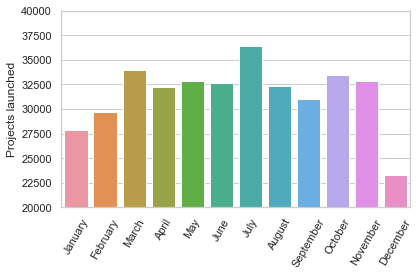

In [34]:
# What are the months with most/less projects launched?:
projects_per_month = df.groupby([df['launched'].dt.month]).count()['category']
projects_per_month.index = [calendar.month_name[i] for i in projects_per_month.index]

#Plot
sns.set(style="whitegrid")
sns.barplot(projects_per_month.index, projects_per_month.values)
plt.ylim(20000, 40000)
plt.ylabel('Projects launched')
plt.xticks(rotation=60)
plt.tight_layout()
plt.savefig('projects_seasonality.png', dpi=150, bbox_inches='tight')

Though there are a relatively constant flux of creation and entrepreneurship, it seems that spring and summer is crowfunding season. 

For further analysis, we can group the launching rate per category too:  

In [35]:
# Group by launch month and category
projects_per_mon_cat = df.groupby(
                                ([df['launched'].dt.month_name()
                                  .str.slice(stop=3),
                                  'main_category']
                                 )).count()['ID']
projects_per_mon_cat

launched  main_category
Apr       Art              2377
          Comics            895
          Crafts            670
          Dance             371
          Design           2420
                           ... 
Sep       Music            4070
          Photography       878
          Publishing       3315
          Technology       2837
          Theater           829
Name: ID, Length: 180, dtype: int64

For example, What are the most launched categories launched in December?: 

In [36]:
print('Projects launched in December through 2009-2017:')
print(" ")
print(projects_per_mon_cat.loc[('Dec', )].sort_values(ascending=False))

Projects launched in December through 2009-2017:
 
main_category
Film & Video    3891
Music           3313
Publishing      2494
Technology      2337
Games           1995
Design          1938
Art             1637
Fashion         1496
Food            1482
Photography      583
Theater          562
Crafts           522
Comics           450
Journalism       319
Dance            245
Name: ID, dtype: int64


## Question 3: How the platform and product areas evolved through the years?

Now let's get a glance on the performance of each project type through time and, incidentally, the evolution of the platform itself. How different creators seeking funding were discovering the platform?

To start, we can group the projects according its launch year and category: 

In [37]:
# Group projects by launch year and type 
df = df[~(df.launched == df.launched.describe()['first'])]
projects_per_yr_cat = df.groupby(
                                [df['launched'].dt.year, 'main_category']
                                 ).count()['ID']
projects_per_yr_cat

launched  main_category
2009      Art              169
          Comics            23
          Crafts            11
          Dance              8
          Design            31
                          ... 
2018      Music             18
          Photography        2
          Publishing        16
          Technology        11
          Theater            2
Name: ID, Length: 149, dtype: int64

This data shows way better info in a plot. But, there are 15 project types, so the plot can get a little crowded/messy. Better, we can group the projects in 6 different product areas: __Design__ that reunites Design, Fashion and Crafted products, __Printed__ that gather Publishing, Comics and Journalism products, Tech and Games products are represented in __Tech__, as Art, Dance and Theater forms the __Scenic__ area. Film & Video, Music and Photography are grouped in __Audiovisual__. __Food__ is on their own. Because the dataset is up to January 2018, this year is skipped from this plot.

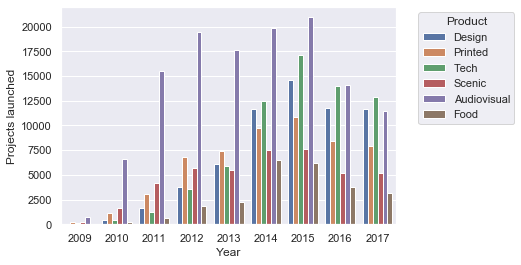

In [38]:
#Hoy many projects were launched in the different areas through the years?
years_list = range (2009,2018)
def extract_projects_cat_year(project_category):
    '''Extract the number of projects per category per year from 
       the projects_per_yr_cat grouping series to an array.
        
        Args:
        project_category (str): main category
        
        Return:
        np.array(launched_list): array of ints with the amount of project_category launches per year       
    '''        
    launched_list = []
    for i in years_list:
        launched_list.append(projects_per_yr_cat.loc[(i, project_category)])
    return np.array(launched_list)

design_launches_arr = (extract_projects_cat_year('Fashion') + 
                       extract_projects_cat_year('Design') + 
                       extract_projects_cat_year('Crafts')
                      )

printed_launches_arr = (extract_projects_cat_year('Publishing') + 
                        extract_projects_cat_year('Comics') + 
                        extract_projects_cat_year('Journalism')
                       )

tech_launches_arr = (extract_projects_cat_year('Technology') + 
                     extract_projects_cat_year('Games') 
                    )

scenic_launches_arr = (extract_projects_cat_year('Art') + 
                       extract_projects_cat_year('Dance') + 
                       extract_projects_cat_year('Theater')                       
                      )

audiovisual_launches_arr = (extract_projects_cat_year('Film & Video') + 
                            extract_projects_cat_year('Photography') + 
                            extract_projects_cat_year('Music')
                           )

food_launches_arr = extract_projects_cat_year('Food')

data_plot = pd.DataFrame({
    'Year': years_list, 
    'Design': design_launches_arr,
    'Printed': printed_launches_arr,
    'Tech': tech_launches_arr,
    'Scenic': scenic_launches_arr,
    'Audiovisual': audiovisual_launches_arr,
    'Food': food_launches_arr})

sns.set(style="darkgrid")
sns.set_color_codes("muted")
sns.barplot(x='Year', y='value', hue='variable', 
            data=pd.melt(data_plot, ['Year']),
           )

plt.xlabel('Year')
plt.ylabel('Projects launched')
plt.legend(title='Product', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.savefig('projects_evolution.png', dpi=150, bbox_inches='tight')

We can see that the platform reach a good general performace in around three-four years, alongside a steady increase of printed, tech and food products. From 2015 onwards is evident a decrease in the number of projects launched. What could happened? a natural cycle of crowdfunding hype?, Undermined reputation due to bad projects?, A new tendency behind the curtain? Many insights is still under cover of the data!      